# Plot correlation function
This notebook is based on `correlation_function.py` that will produce the `.npz` file that is used here

In [1]:
%load_ext autoreload
%autoreload 2

from plot_correlations_from_npz import *
%config InlineBackend.figure_format ='retina'


### Reading files

In [2]:
input_dir = "../../experimental_data/data_dany/data_dany_output_20220614/"
# input_dir = "../../experimental_data/data_dany/corr_tests/"

mk_missing_dir(os.path.join(input_dir, "plots/correlations"))

corralations_filenames = get_input_files(input_dir, keyword="correlations", ext=".npz")

# Filter if wanted
corralations_filenames = [cf for cf in corralations_filenames if not "_r" in cf]

conditions = ["acetate", "glycerol", "glucose", "glucoseaa"]
promoters = ['hi1', 'hi3', 'med2', 'med3', 'rrnB', 'rpsB', 'rpmB', 'rplN']

corr_dict = {}
gamma_lambdas = {}
mean_lambdas = {}
mean_qs = {}
gamma_qs = {}
mean_sq_conc = {}

for cf in corralations_filenames:
    data = np.load(cf, allow_pickle=True)

    data_set_name = re.split('_f\d', cf.split('/')[-1] )[0]
    print(data_set_name, end="\t") 

    corr_dict[data_set_name] = Correlation_function(data['correlations'])
    
    # Collect relevant parameters 
    gamma_lambdas[data_set_name] = data['gamma_lambda']
    mean_lambdas[data_set_name] = data['mean_lambda']
    
    gamma_qs[data_set_name] = data['gamma_q']
    mean_qs[data_set_name] = data['mean_q']
    
    prediction_file = cf.replace("correlations.npz", "prediction.csv")
    cells = df2ggp_cells(pd.read_csv(prediction_file, skiprows=header_lines(prediction_file), 
                                 dtype={"parent_id":str, "cell_id":str}))
    
    mean_sq_conc[data_set_name] = mean_quantity(cells)**2
    

acetate_hi1	acetate_hi3	acetate_med2	acetate_med3	glucose_hi1	glucose_hi3	glucose_med2	glucose_med3	glucoseaa_hi1	glucoseaa_hi3	glucoseaa_med2	glucoseaa_med3	glycerol_hi1	glycerol_hi3	glycerol_med2	glycerol_med3	

In [3]:
def sort_dict(indict, sort_key):
    out = {}
    for sk in sort_key:
        for k in indict.keys():
            if sk in k:
                out[k] = indict[k]
    return out

In [4]:
conditions_to_plot =  ["acetate", "glycerol", "glucose_", "glucoseaa_"]
conditions_to_plot =  ["acetate", "glycerol", "glucose_"]
corr_dict = sort_dict(corr_dict,conditions_to_plot)

gamma_lambdas = sort_dict(gamma_lambdas, conditions_to_plot)
gamma_qs = sort_dict(gamma_qs, conditions_to_plot)
mean_lambdas = sort_dict(mean_lambdas, conditions_to_plot)


# By condition

In [10]:
%autoreload 2
for condition in conditions:
    mk_missing_dir(os.path.join(input_dir, "plots/correlations_synthetic/"))
    mk_missing_dir(os.path.join(input_dir, "plots/correlations_synthetic/", condition))
    
    plot_dir = os.path.join(input_dir, "plots/correlations_synthetic/", condition ,"{:s}_{:s}_{:s}_{:s}.pdf")
    
    ### Concentration
    plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
                            "c(t+dt)", "c(t)", 
                            plot_file=plot_dir.format(condition, "corr", "c", "c"), 
                            label=get_filtered_keys(corr_dict, condition), 
                            mean_lambda = get_filtered_values(mean_lambdas, condition),
                            scale_t=True, 
#                                 ylim=[-0.1, 1.1], 
                            xlim=[0, 3], 
                            err_style="fill", 
                            log=False, 
                            min_joint_number=1,
                            color_by="promoter")

    ### Growth
    plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
                            "l(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(condition, "cov", "l", "l"), 
                            label=get_filtered_keys(corr_dict, condition, keep="both"), 
                            gamma=get_filtered_values(gamma_lambdas, condition), 
                            mean_lambda = get_filtered_values(mean_lambdas, condition),
                            ylabel=r"Cov $(\lambda(t+dt),\lambda(t))/\bar{\lambda}^2$",
                            scale_t=True,
                            normalize = get_filtered_values(mean_lambdas, condition)**2,
                            ylim=[1e-3, 0.2], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=True, 
                            legend=False, 
                            cov=True,
                            min_joint_number=1,
                            color_by="promoter")
                             
    plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
                            "l(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(condition, "corr", "l", "l"), 
                            label=get_filtered_keys(corr_dict, condition, keep="both"), 
                            gamma=get_filtered_values(gamma_lambdas, condition), 
                            mean_lambda = get_filtered_values(mean_lambdas, condition),
                            ylabel=r"Correlation $\lambda(t+dt),\lambda(t)$",
                            scale_t=True, 
                            ylim=[2e-2, 1.5], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=True, 
                            min_joint_number=1, 
                            legend=False, 
                            color_by="promoter")
    
    ### Production
    plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
                            "q(t+dt)", "q(t)", 
                            plot_file=plot_dir.format(condition, "corr", "q", "q"), 
                            label=get_filtered_keys(corr_dict, condition, keep="both"), 
                            gamma=get_filtered_values(gamma_qs, condition), 
                            mean_lambda = get_filtered_values(mean_lambdas, condition),
                            ylabel=r"Correlation $q(t+dt),q(t)$",
                            scale_t=True, 
                            ylim=[2e-2, 1.5], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=True, 
                            min_joint_number=1,
                            color_by="promoter")
    
    ### Cross
    plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
                            "q(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(condition, "corr", "q", "l"), 
                            label=get_filtered_keys(corr_dict, condition, keep="promoter"), 
                            mean_lambda = get_filtered_values(mean_lambdas, condition),
                            ylabel=r"Corr $(q(t+dt),l(t))$",
                            scale_t=True, 
                            ylim=[None, None],
                            highlight_x0=True,
                            highlight_y0=True,
                            xlim=[-2, 2], 
                            err_style="fill", 
                            min_joint_number=1,
                            color_by="promoter")

Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/acetate/acetate_corr_c_c.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/acetate/acetate_cov_l_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/acetate/acetate_corr_l_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/acetate/acetate_corr_q_q.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/acetate/acetate_corr_q_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glycerol/glycerol_corr_c_c.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glycerol/glycerol_cov_l_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glycerol/gl

No handles with labels found to put in legend.


Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucose/glucose_corr_q_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucoseaa/glucoseaa_corr_c_c.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucoseaa/glucoseaa_cov_l_l.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucoseaa/glucoseaa_corr_l_l.pdf


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucoseaa/glucoseaa_corr_q_q.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations_synthetic/glucoseaa/glucoseaa_corr_q_l.pdf


# By promoter

In [ ]:


%load_ext autoreload
%autoreload 2

from plot_correlations_from_npz import *

for promoter in promoters[:]:
    mk_missing_dir( os.path.join(input_dir, "plots/correlations/"))
    plot_dir = os.path.join(input_dir, "plots/correlations/", promoter ,"{:s}_{:s}_{:s}_{:s}.pdf")
    mk_missing_dir( os.path.join(input_dir, "plots/correlations/", promoter))
    
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "l(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(promoter, "corr", "l", "l"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="condition"), 
                            gamma=get_filtered_values(gamma_lambdas, promoter), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                            ylabel=r"Correlation $\lambda(t+dt),\lambda(t)$",
                            scale_t=True, 
                            ylim=[2e-2, 1.5], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=True, 
                            min_joint_number=1)
    
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "l(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(promoter, "corr_real_time", "l", "l"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="condition"), 
                            gamma=get_filtered_values(gamma_lambdas, promoter), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                            ylabel=r"Correlation $\lambda(t+dt),\lambda(t)$",
                            scale_t=False, 
                            ylim=[0.01, 1], 
                            xlim=[0, 400], 
                            err_style="fill", 
                            log=True, 
                            min_joint_number=2000)
    
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "l(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(promoter, "cov", "l", "l"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="condition"), 
                            gamma=get_filtered_values(gamma_lambdas, promoter), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                            normalize = get_filtered_values(mean_lambdas, promoter)**2,
                            ylabel=r"Norm. covariance $\lambda(t+dt),\lambda(t)/\bar{\lambda}^2$",
                            scale_t=True, 
                            ylim=[1e-3, 0.2], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=True, 
                            min_joint_number=1, 
                            cov=True)
    
#     plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
#                             "l(t+dt)", "q(t)", 
#                             plot_file=plot_dir.format(promoter, "corr", "l", "q"), 
#                             label=get_filtered_keys(corr_dict, promoter, keep="both"), 
#                             mean_lambda = get_filtered_values(mean_lambdas, promoter),
#                             ylabel=r"Correlation $\lambda(t+dt),q(t)$",
#                             scale_t=True, 
#                             ylim=[-0.25, 0.55], 
#                             xlim=[-2, 2], 
#                             err_style="fill", 
# #                             log=True, 
#                             min_joint_number=1,
#                             highlight_x0=True,
#                             highlight_y0=True,)
    
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "q(t+dt)", "l(t)", 
                            plot_file=plot_dir.format(promoter, "corr", "q", "l"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="both"), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                            ylabel=r"Correlation $q(t+dt),\lambda(t)$",
                            scale_t=True, 
                            ylim=[-0.25, 0.75], 
                            xlim=[-2, 2], 
                            err_style="fill", 
#                             log=True, 
                            min_joint_number=1,
                            highlight_x0=True,
                            highlight_y0=True,)
    
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "q(t+dt)", "q(t)", 
                            plot_file=plot_dir.format(promoter, "corr", "q", "q"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="both"), 
#                             gamma=get_filtered_values(gamma_qs, promoter), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                            ylabel=r"Correlation $q(t+dt),q(t)$",
                            scale_t=True, 
#                             ylim=[1e-3, 1], 
                            xlim=[0, 2], 
                            err_style="fill", 
#                             log=True, 
                            min_joint_number=1, 
                            highlight_x0=True)
    
#     plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
#                             "q(t+dt)", "q(t)", 
#                             plot_file=plot_dir.format(promoter, "corr_real_time", "q", "q"), 
#                             label=get_filtered_keys(corr_dict, promoter, keep="both"), 
# #                             gamma=get_filtered_values(gamma_qs, promoter), 
#                             mean_lambda = get_filtered_values(mean_lambdas, promoter),
#                             ylabel=r"Correlation $q(t+dt),q(t)$",
# #                             scale_t=True, 
# #                             ylim=[1e-3, 1], 
#                             xlim=[0, 200], 
#                             err_style="fill", 
# #                             log=True, 
#                             min_joint_number=1, 
#                             highlight_x0=True)
        
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                            "q(t+dt)", "q(t)", 
                            plot_file=plot_dir.format(promoter, "cov", "q", "q"), 
                            label=get_filtered_keys(corr_dict, promoter, keep="both"), 
#                             gamma=get_filtered_values(gamma_qs, promoter), 
                            mean_lambda = get_filtered_values(mean_lambdas, promoter),
                             normalize = get_filtered_values(mean_qs, promoter)**2,
                            ylabel=r"Norm. covariance $q(t+dt),q(t) /\bar{q}^2$",
                            scale_t=True, 
#                             ylim=[1e1, 1e4], 
                            xlim=[0, 2], 
                            err_style="fill", 
                            log=False, 
                            min_joint_number=1, 
                            cov=True, 
                            highlight_x0=True)

## Tiles

Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_acetate_hi1_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_acetate_hi3_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_acetate_med2_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_acetate_med3_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_glycerol_hi1_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_glycerol_hi3_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_glycerol_med2_tiles_.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/tiles/corr_glycerol_med3_tiles_.pdf
Saved in ../../e

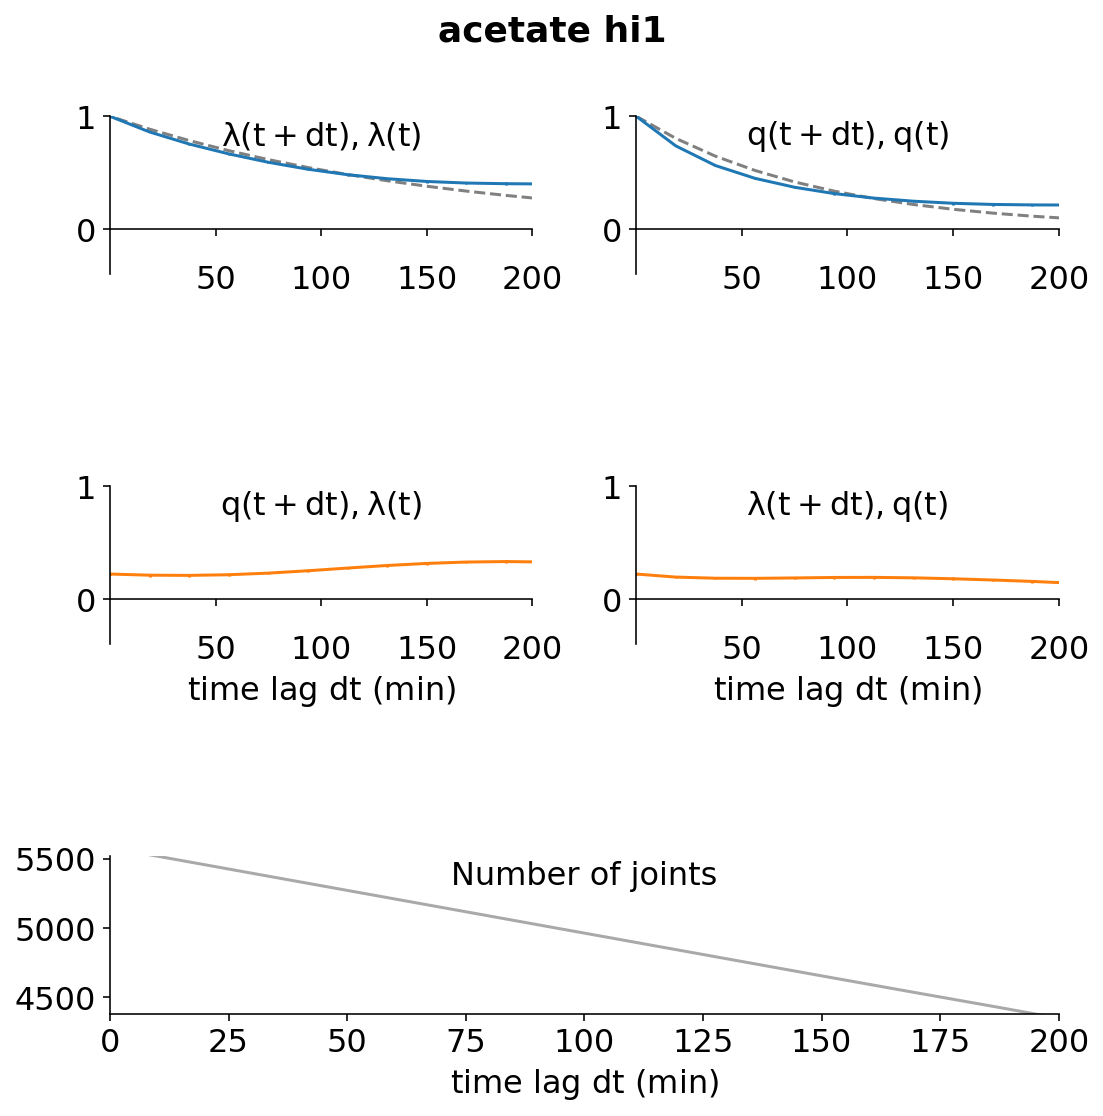

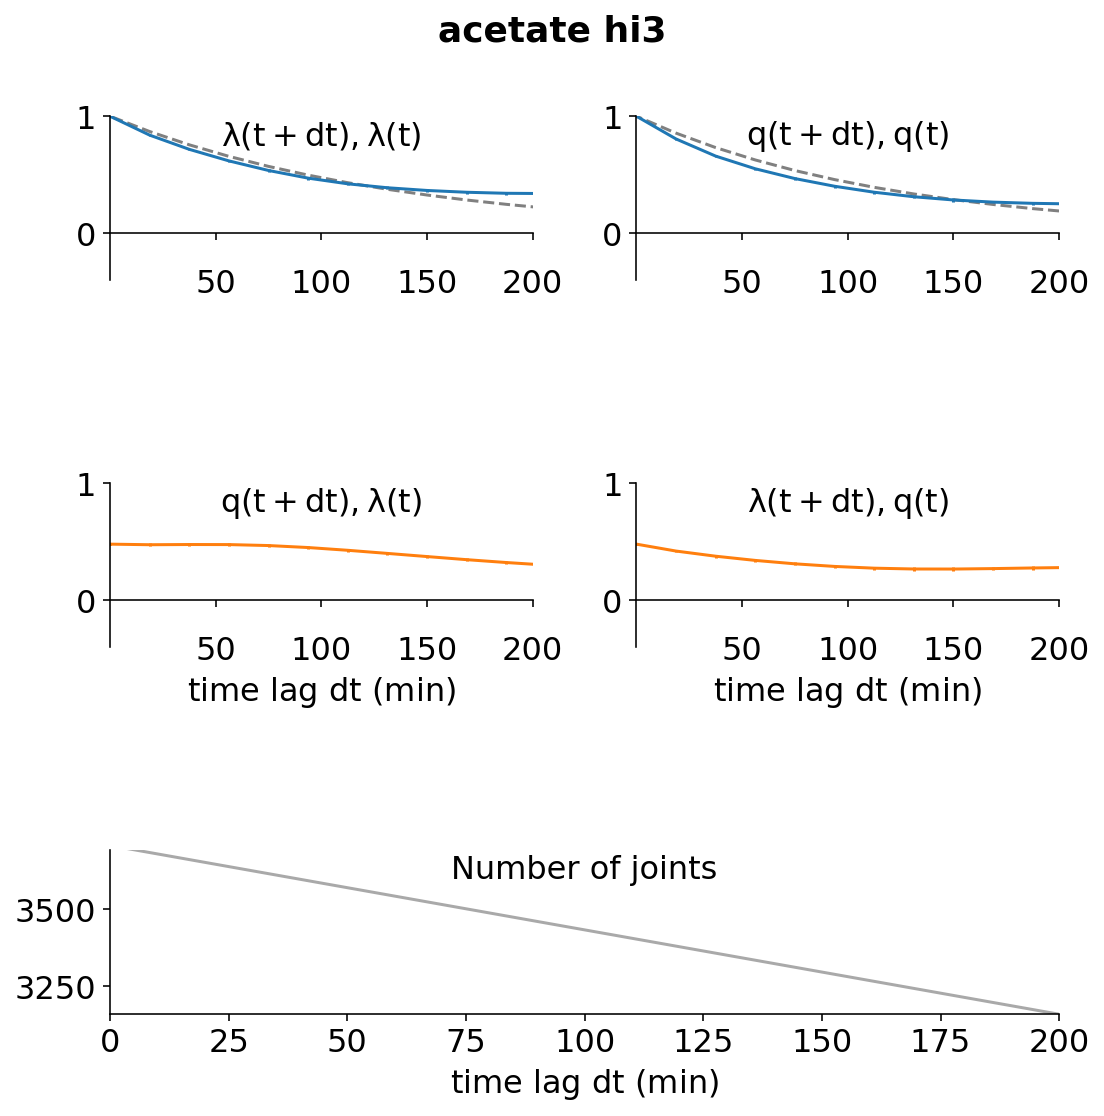

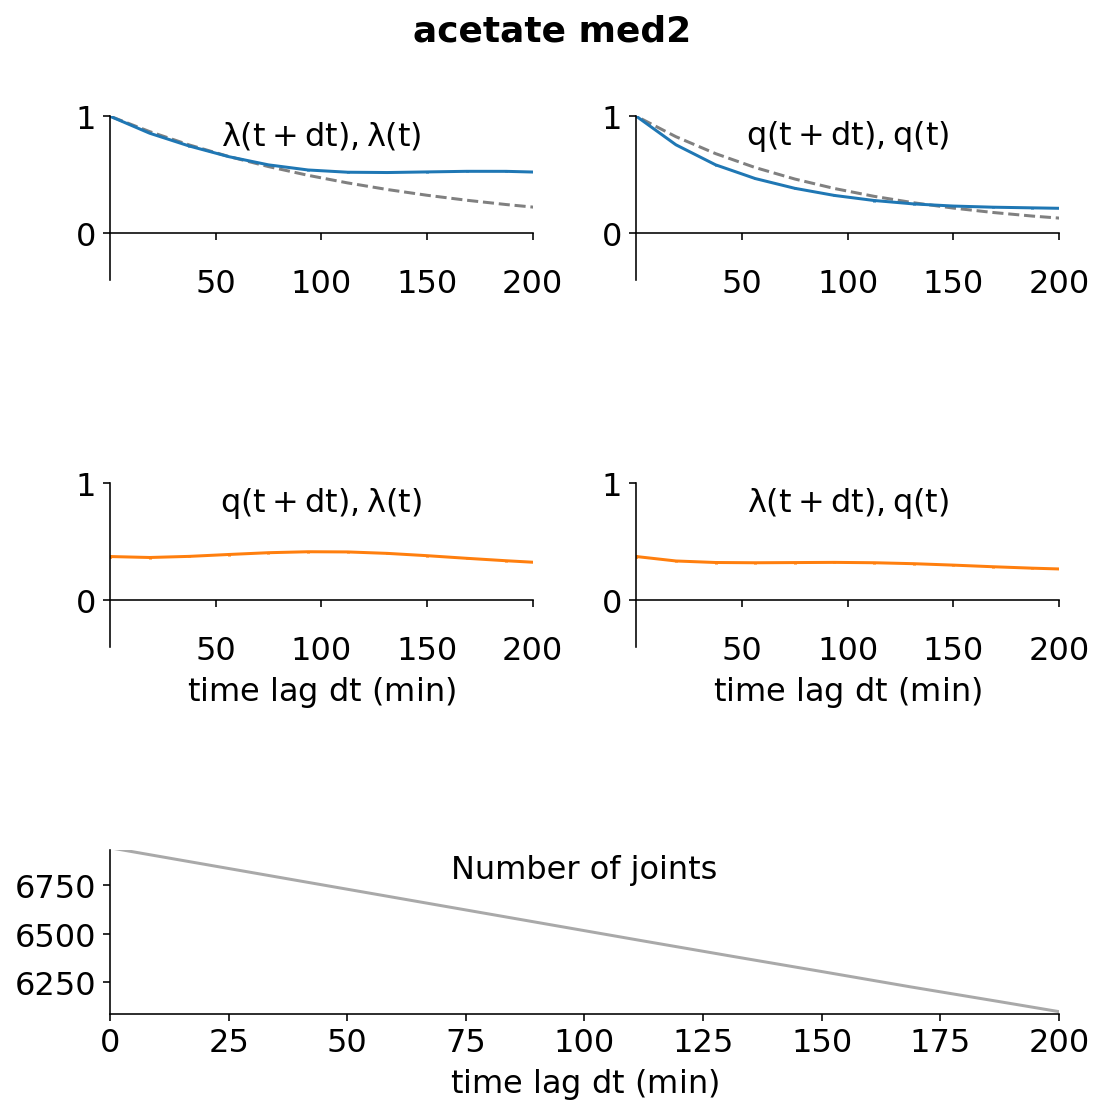

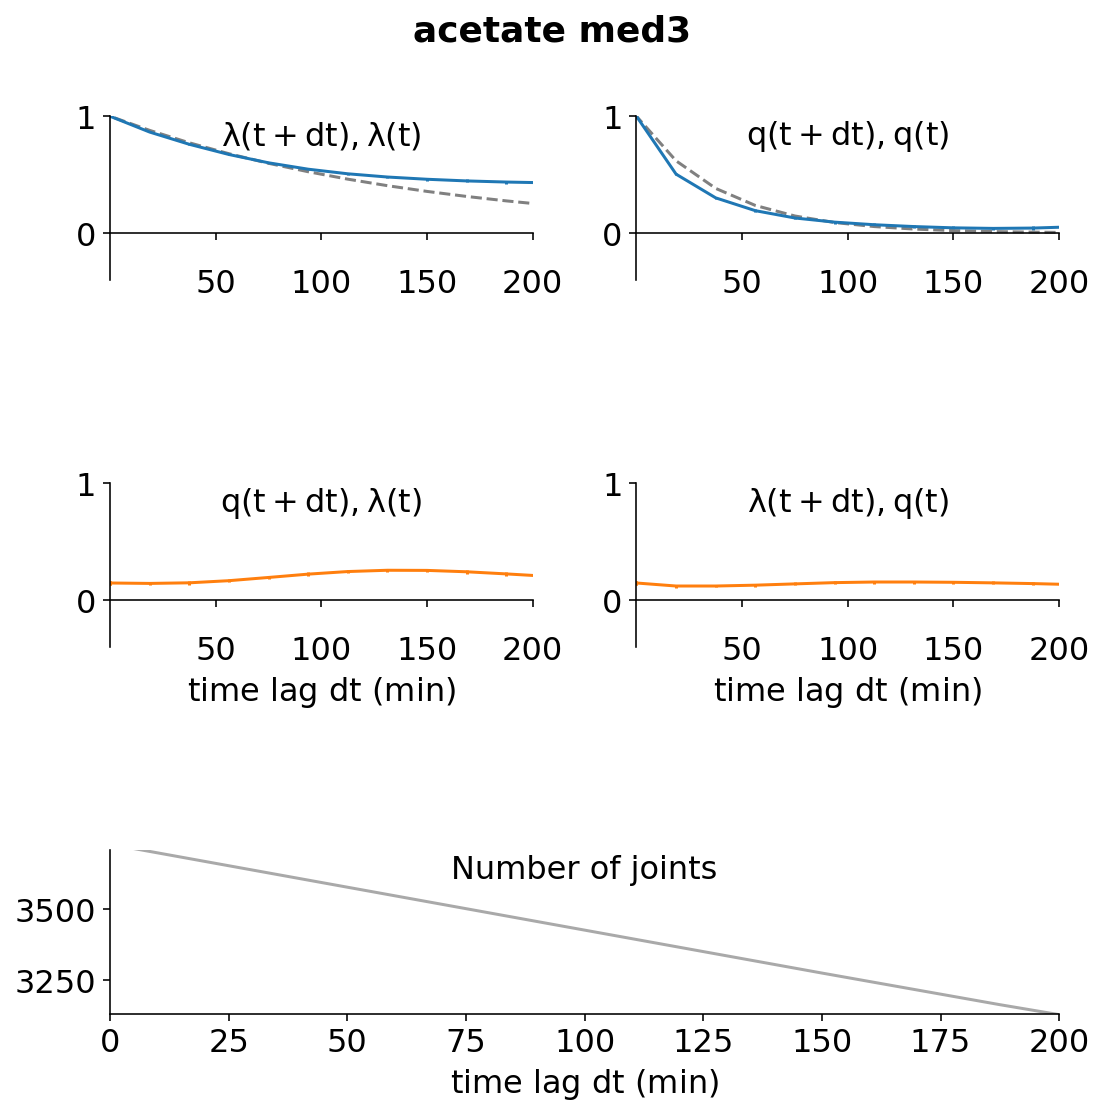

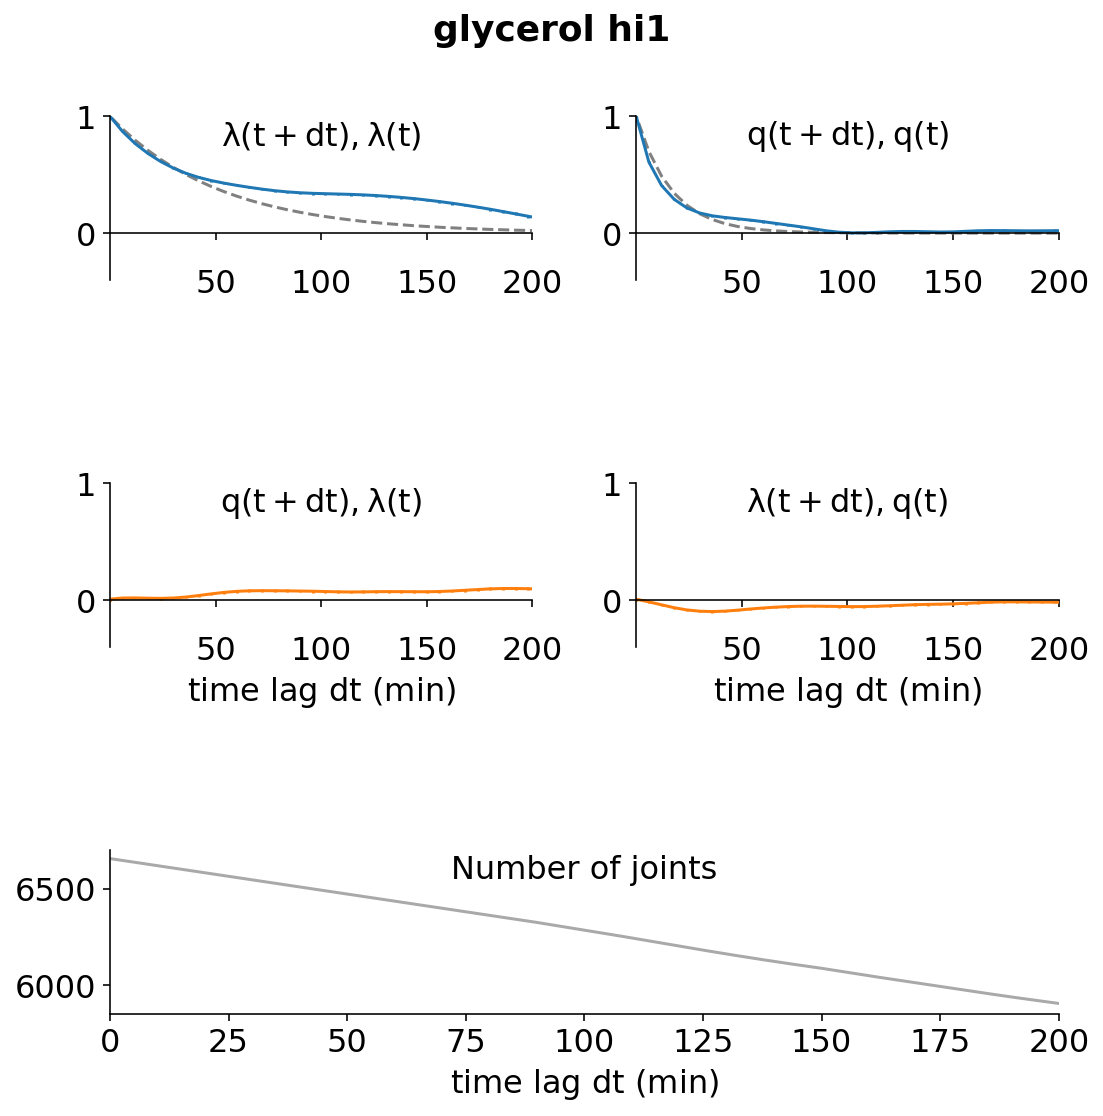

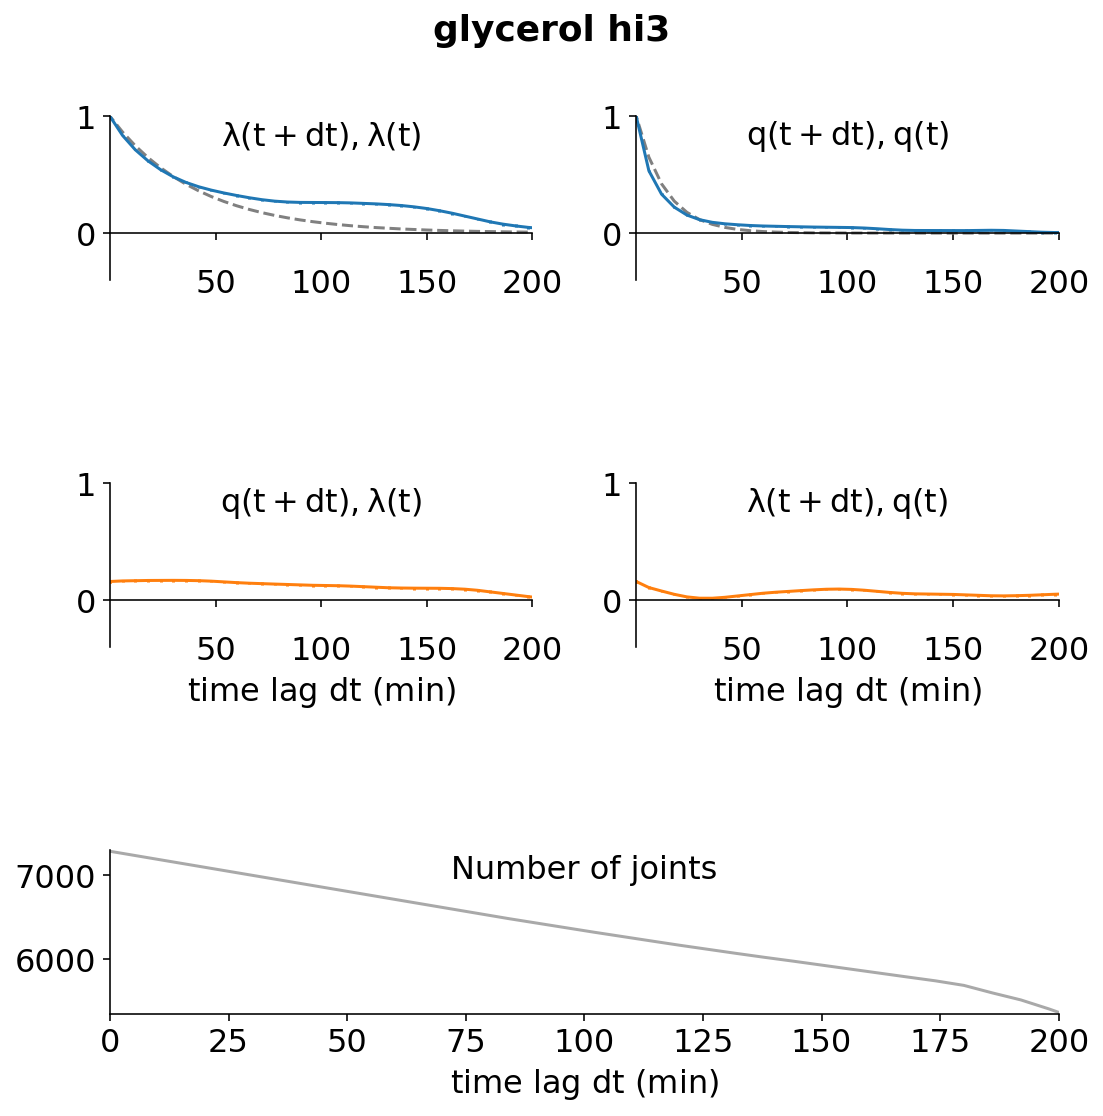

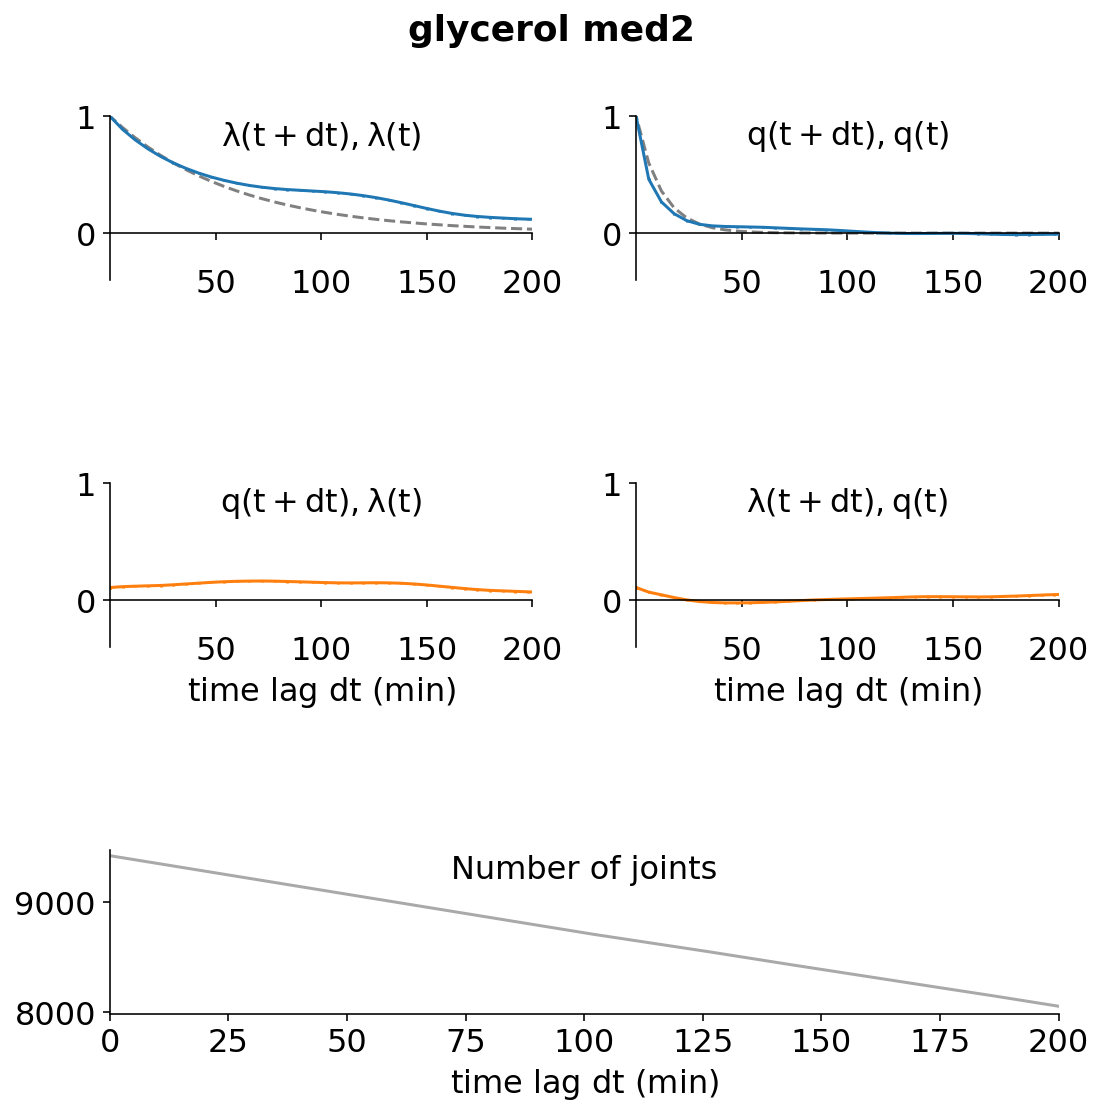

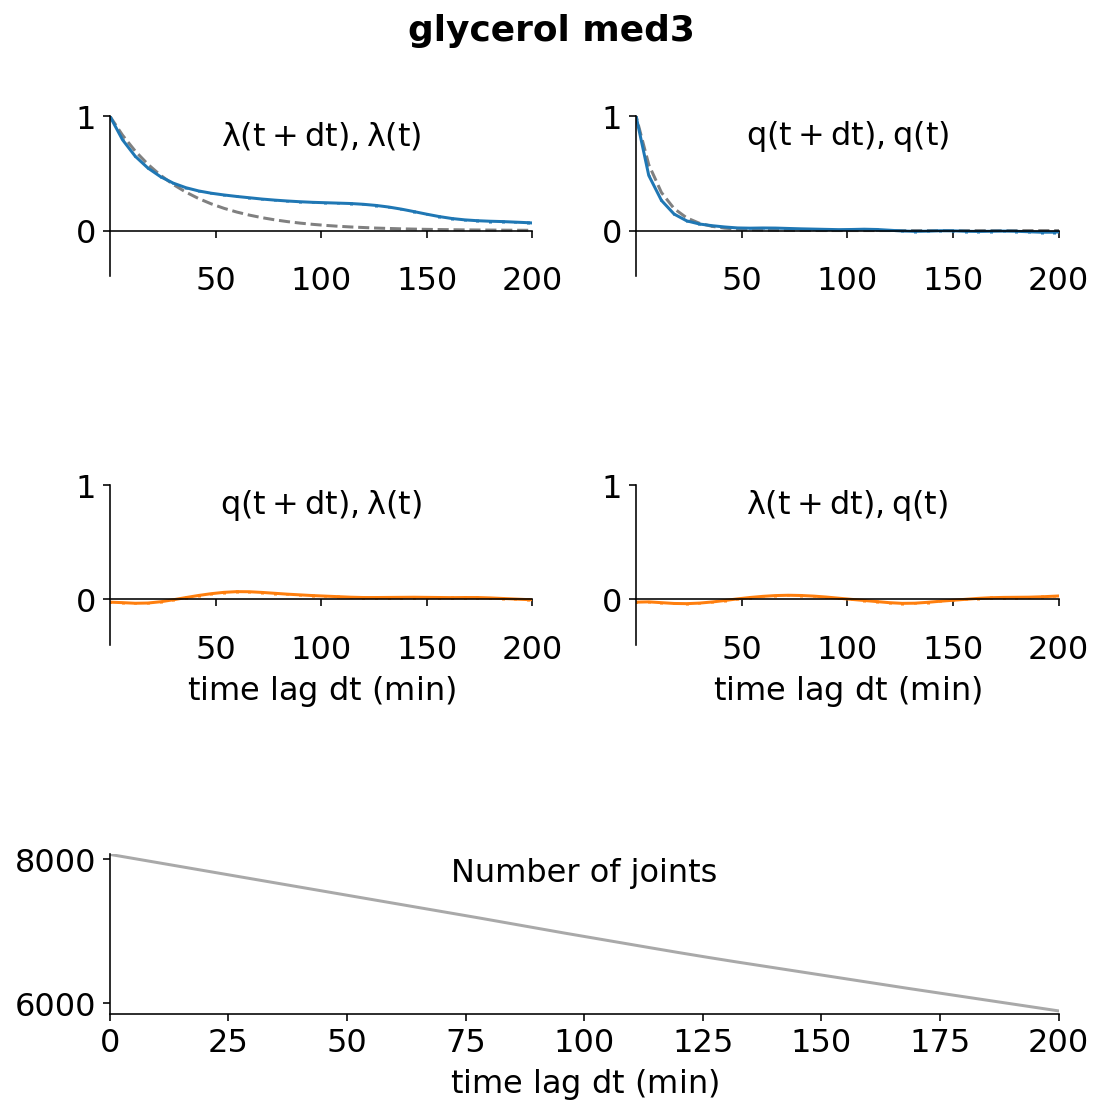

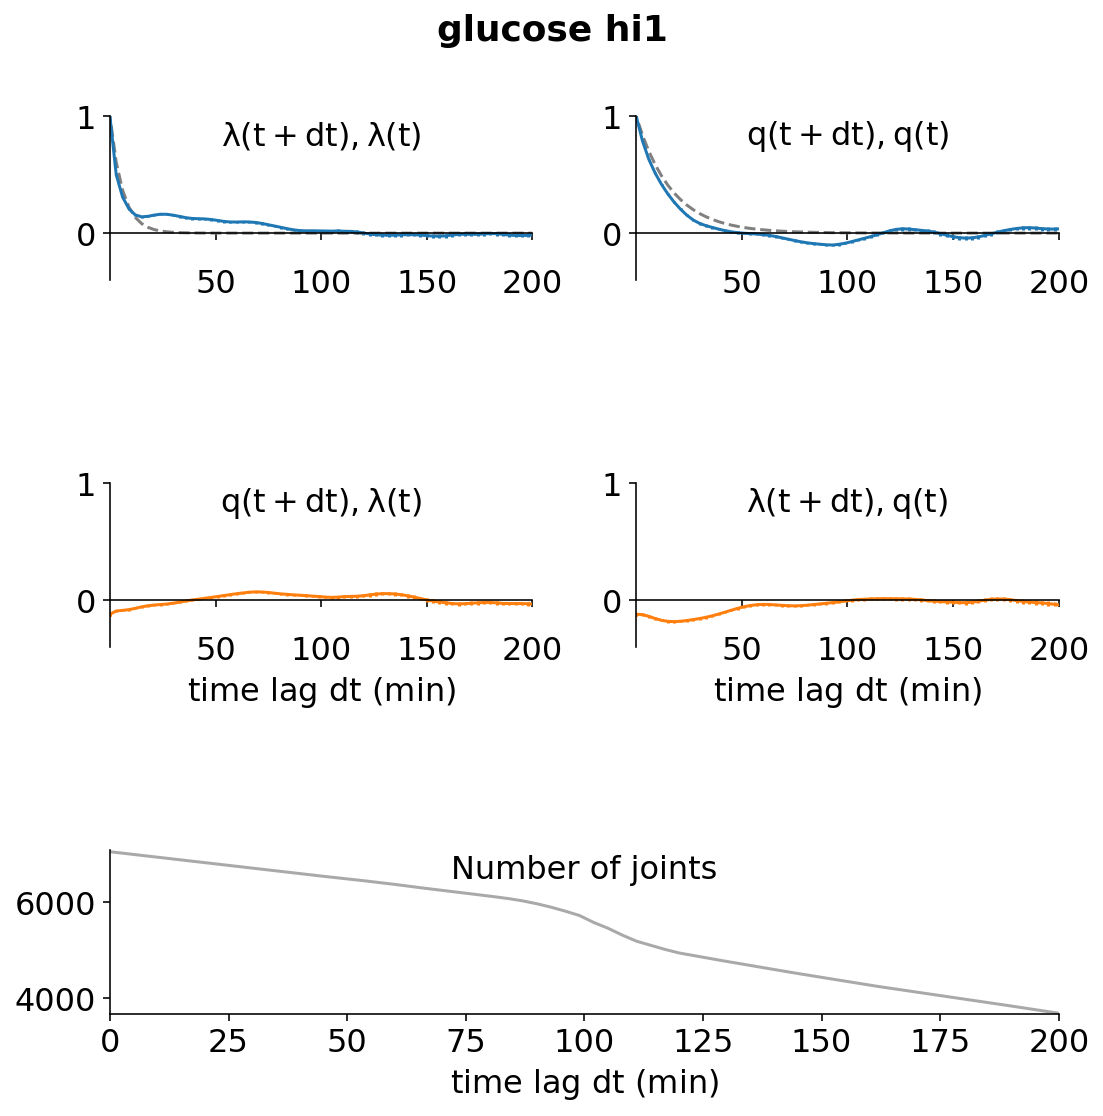

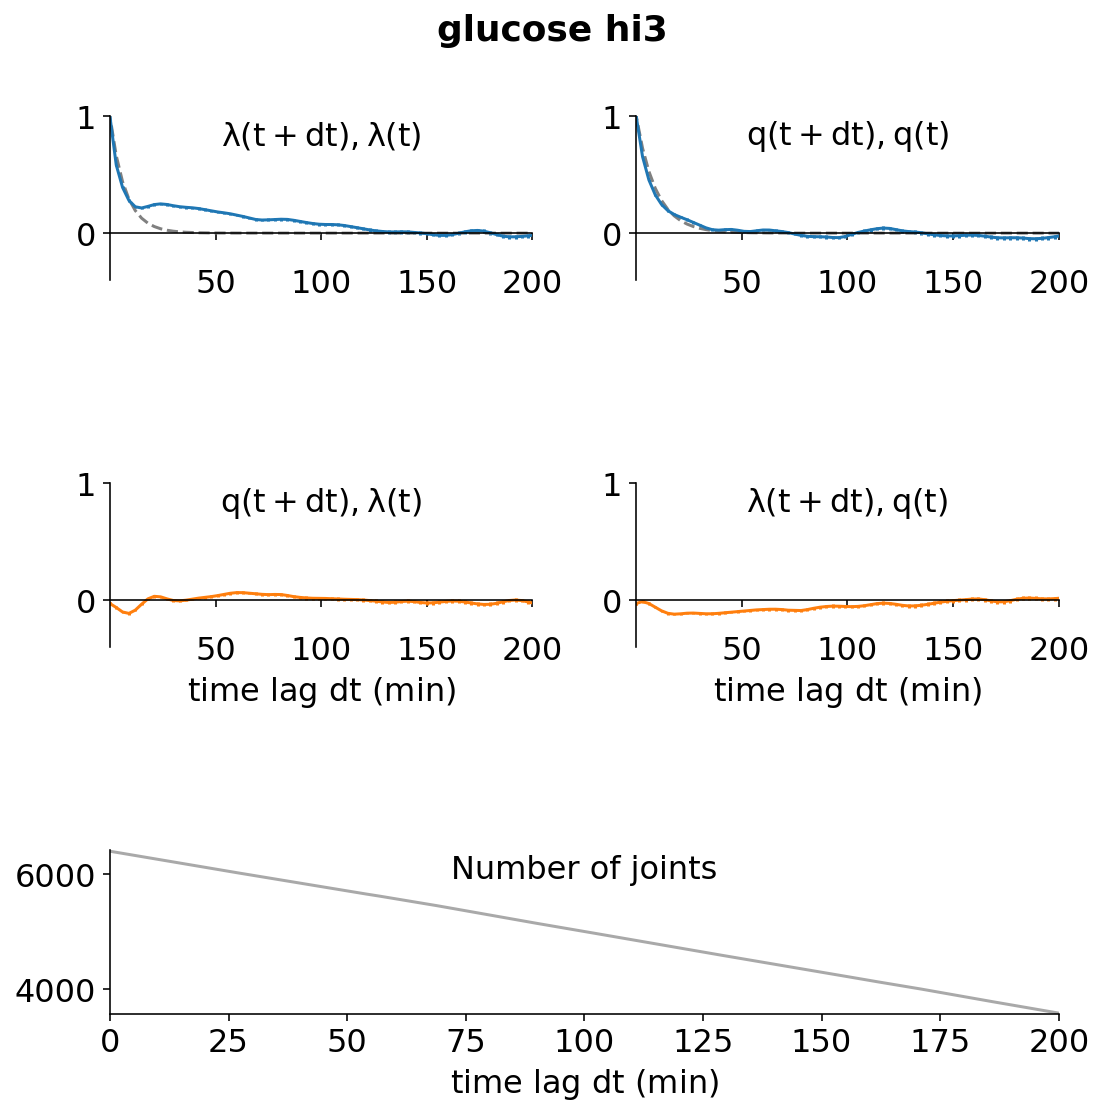

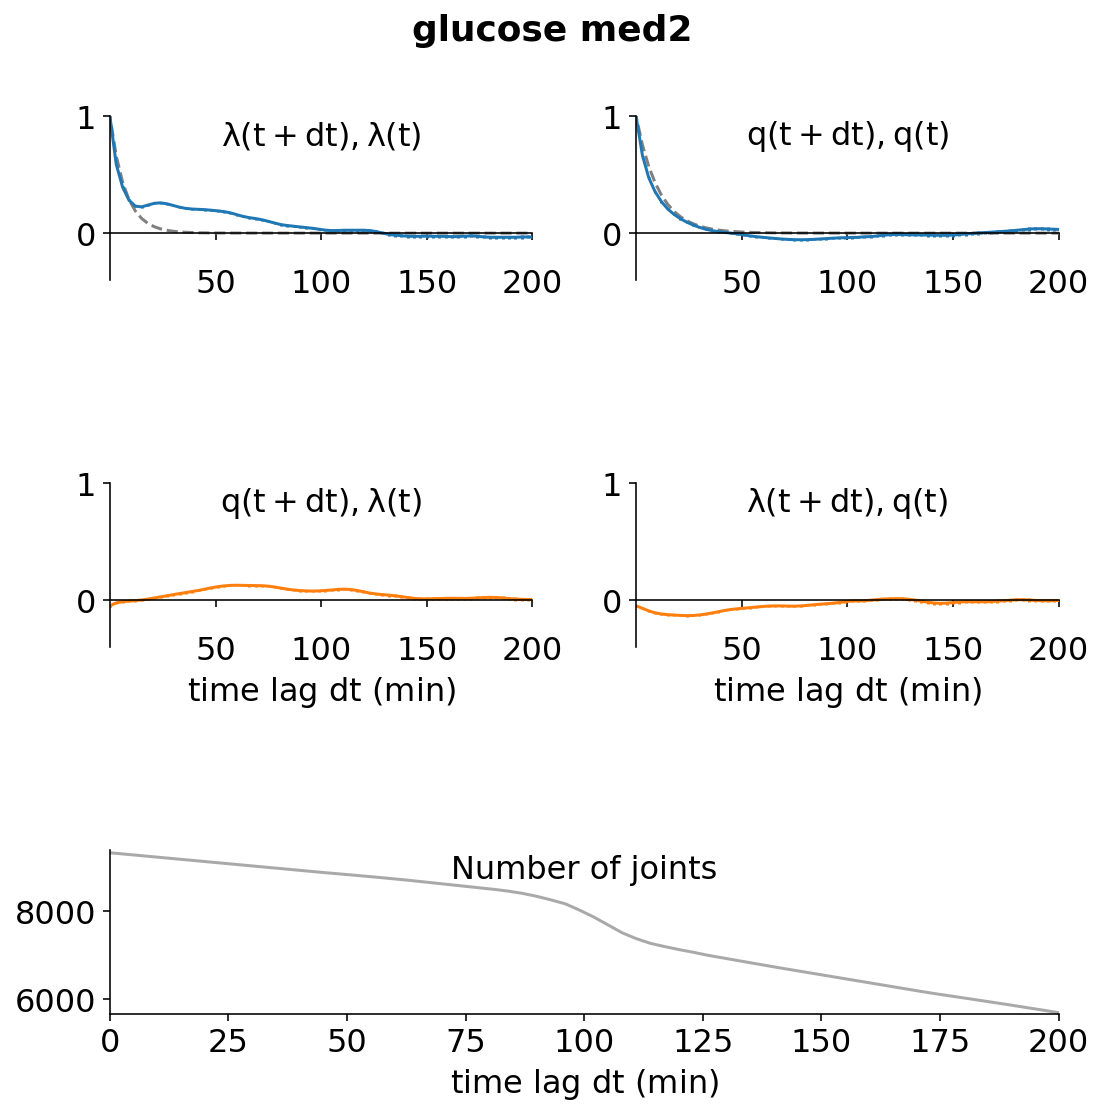

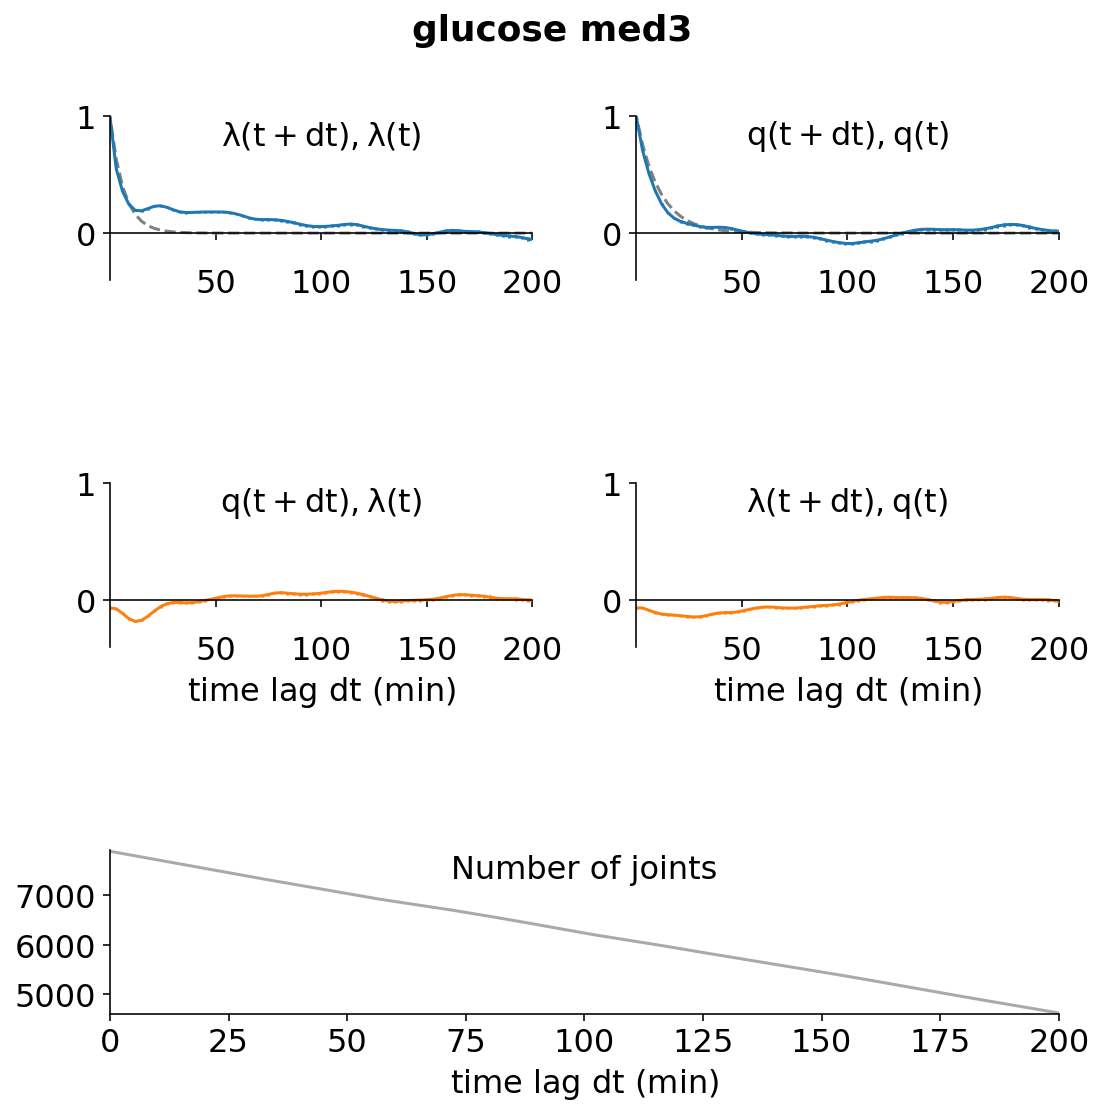

In [11]:
for k in corr_dict.keys():  
    plot_dir = os.path.join(input_dir, "plots/correlations/", "tiles" ,"{:s}_{:s}_{:s}_{:s}.pdf")
    mk_missing_dir( os.path.join(input_dir, "plots/correlations/", "tiles"))
    plot_correlation_tiles(corr_dict[k], 
                            gamma_lambda=gamma_lambdas[k], 
                            gamma_q=gamma_qs[k], 
                            min_joint_number=1500, 
                            xlim=[0,200],
                            title=k, 
                            plot_file=plot_dir.format("corr", k, "tiles", ""))

In [ ]:
plot_xy_correlation(corr_dict["acetate_hi1"], "c(t+dt)", "c(t)", ylim=[-0.2, 1], xlim=[0, 1500], 
                mean_lambda=mean_lambdas["acetate_hi1"])
